# Introduction
In this notebook, we will explore a dataset about e-commerce transactions. 
We will analyze the dataset, clean it, transform it, make some conclusions and then will make a model that 
will give predictions on user ratings.
# Imports

In [212]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import r_regression
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Reading the dataset

In [213]:
df = pd.read_csv('data.csv')

In [214]:
df.head(10)

,OrderID,OrderDate,ShipDate,CustomerID,CustomerName,Segment,Country,City,State,PostalCode,...,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating
0,103985.0,2022-03-26,2023-06-06,2191.0,Bob Smith,Undefined,NaN,Madrid,BC,41008.0,...,Books,Phones,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,NaN
1,105550.0,2023-12-21,2023-03-15,2865.0,Eve Black,Home Office,Canada,InvalidCity,ON,98310.0,...,NaN,Phones,NaN,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0
2,102313.0,2022-04-21,2022-11-03,2672.0,Charlie Brown,Home Office,Unknown,InvalidCity,NY,78040.0,...,Electrnics,Lamps,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0
3,103092.0,2022-04-15,2023-09-26,2805.0,David White,Undefined,Canada,New York,CA,21721.0,...,Electrnics,Lamps,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0
4,102460.0,2023-10-07,2022-12-26,2212.0,NaN,Consumer,Germany,Berlin,Undefined,43484.0,...,Electronics,Binders,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0
5,108837.0,2023-03-15,2023-08-18,2233.0,Alice Johnson,NaN,USA,Madrid,CA,52646.0,...,Toys,Phones,Office Chair,3300.0,11.0,0.0,100.0,10.0,NaN,3.0
6,102914.0,2022-06-28,2023-01-07,2664.0,David White,Corporate,Spain,Berlin,ON,44953.0,...,Office Supplies,Binders,Desk Lamp,3794.0,4.0,-10.0,NaN,100.0,Bank Transfer,2.0
7,100096.0,2023-01-02,2022-07-11,2003.0,Charlie Brown,NaN,USA,NaN,BC,80231.0,...,NaN,Lamps,Gaming Table,2009.0,19.0,NaN,NaN,100.0,NaN,6.0
8,103043.0,2022-09-17,2023-08-09,2670.0,Eve Black,Home Office,Spain,Toronto,FL,36753.0,...,Office Supplies,IncorrectCat,Gaming Table,1678.0,2.0,10.0,0.0,10.0,Crypto,NaN
9,102231.0,2023-11-12,2023-12-20,2921.0,Bob Smith,Small Business,USA,Berlin,TX,43769.0,...,NaN,NaN,Office Chair,2254.0,18.0,110.0,-500.0,0.0,Cash,4.0


- First thing, I see is that there are a lot of categorical columns: CustomerName, Segment, Country, City, State...
- Secondly, whe have a lot of nulls but as values such as: "undefined", "Unknown", "Invalid City". Let's investigate further.
- We also have some date columns: OrderDate and ShipDate.
- It is strange tho, how the customerID is different but the CustomerName is the same.
- There are some incosistencies. There is an "iPhone 14" in the "office supplies" category, an "office chair" is categorized as "Electronics". There is not a clear algorithm for these incosistencies.

In [215]:
df.describe(include='object')

,OrderDate,ShipDate,CustomerName,Segment,Country,City,State,Region,ProductCategory,SubCategory,ProductName,PaymentMethod
count,9985,9979,8372,8379,8547,8545,8741,8325,8712,8603,8300,8590
unique,731,730,5,5,6,6,7,5,7,6,5,6
top,2023-08-24,2023-11-05,Bob Smith,Small Business,Germany,Madrid,BC,Unknown,Electronics,Phones,Binder Set,PayPal
freq,27,29,1722,1763,1478,1449,1269,1713,1285,1497,1683,1496


We see that columns don't have equal results for count, which means there are a lot of NaNs in those column, 
also there are quite a lot of NaNs in CustomerRating.

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   OrderID          9999 non-null   float64
 1   OrderDate        9985 non-null   object 
 2   ShipDate         9979 non-null   object 
 3   CustomerID       9987 non-null   float64
 4   CustomerName     8372 non-null   object 
 5   Segment          8379 non-null   object 
 6   Country          8547 non-null   object 
 7   City             8545 non-null   object 
 8   State            8741 non-null   object 
 9   PostalCode       9999 non-null   float64
 10  Region           8325 non-null   object 
 11  ProductID        9990 non-null   float64
 12  ProductCategory  8712 non-null   object 
 13  SubCategory      8603 non-null   object 
 14  ProductName      8300 non-null   object 
 15  Sales            9997 non-null   float64
 16  Quantity         9616 non-null   float64
 17  Discount     

Let's explore further, the values to see what possible "null" values we have. 

In [217]:
df['CustomerName'].unique()

array(['Bob Smith', 'Eve Black', 'Charlie Brown', 'David White', nan,
       'Alice Johnson'], dtype=object)

In [218]:
df['Segment'].unique()

array(['Undefined', 'Home Office', 'Consumer', nan, 'Corporate',
       'Small Business'], dtype=object)

In [219]:
df['City'].unique()

array(['Madrid', 'InvalidCity', 'New York', 'Berlin', nan, 'Toronto',
       'Paris'], dtype=object)

In [220]:
df['Country'].unique()

array([nan, 'Canada', 'Unknown', 'Germany', 'USA', 'Spain', 'France'],
      dtype=object)

In [221]:
df['State'].unique()

array(['BC', 'ON', 'NY', 'CA', 'Undefined', 'FL', 'TX', nan], dtype=object)

In [222]:
df['Region'].unique()

array(['Unknown', 'East', 'Central', nan, 'South', 'West'], dtype=object)

In [223]:
df['ProductCategory'].unique()

array(['Books', nan, 'Electrnics', 'Electronics', 'Toys',
       'Office Supplies', 'Home Decor', 'Furniture'], dtype=object)

"Electrnics" is clearly just Electronics that is misspelled.

In [224]:
df['SubCategory'].unique()

array(['Phones', 'Lamps', 'Binders', 'IncorrectCat', nan, 'Tables',
       'Chairs'], dtype=object)

In [225]:
df['Profit'].unique()

array([  nan, -500.,  500.,  100.,    0., -100., 1000.])

In [226]:
df['CustomerRating'].unique()

array([ nan,   1.,   3.,  -1.,   2.,   6.,   4., 100.,   5.])

In [227]:
df['PaymentMethod'].unique()

array(['Bank Transfer', 'PayPal', 'Cash', nan, 'Crypto', 'Credit Card',
       'Undefined'], dtype=object)

In [228]:
df['ProductName'].unique()

array(['Office Chair', nan, 'iPhone 14', 'Desk Lamp', 'Gaming Table',
       'Binder Set'], dtype=object)

In [229]:
df['PostalCode'].unique()

array([41008., 98310., 78040., ..., 26834., 83124., 49040.], shape=(9048,))

So now we confirmed, that there "non-null nulls" such as InvalidCity, IncorrectCat.

In [230]:
df.shape

(10000, 22)

We have 22 features and 10000 rows.
Next, let's see if there are dublicated values.

In [231]:
print(df.duplicated().sum())
df[df.duplicated()]

500


,OrderID,OrderDate,ShipDate,CustomerID,CustomerName,Segment,Country,City,State,PostalCode,...,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating
346,106368.0,2023-02-03,2022-12-18,2754.0,Bob Smith,Small Business,Spain,Madrid,NaN,20791.0,...,Electronics,Phones,Office Chair,3235.0,-4.0,NaN,100.0,0.0,Cash,-1.0
639,106874.0,2022-04-01,2022-09-19,2129.0,Alice Johnson,Consumer,Unknown,NaN,NaN,99791.0,...,Electronics,IncorrectCat,Binder Set,1034.0,15.0,10.0,0.0,10.0,Undefined,5.0
665,106205.0,2022-08-07,2022-06-30,2676.0,Eve Black,Consumer,Spain,New York,TX,18637.0,...,Furniture,IncorrectCat,Desk Lamp,2128.0,19.0,0.0,-100.0,NaN,Bank Transfer,-1.0
682,106428.0,2022-01-18,2022-11-03,2571.0,Alice Johnson,Small Business,Unknown,InvalidCity,FL,34069.0,...,Home Decor,Chairs,Office Chair,-88.0,3.0,5.0,-100.0,5.0,Crypto,5.0
686,103219.0,2022-10-05,2023-10-02,2696.0,David White,Corporate,France,Madrid,FL,56031.0,...,Furniture,Chairs,Desk Lamp,1613.0,-4.0,-10.0,100.0,5.0,Undefined,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9934,107405.0,2022-04-04,2023-03-23,2533.0,David White,Corporate,Germany,Paris,NaN,51087.0,...,Office Supplies,IncorrectCat,iPhone 14,361.0,19.0,-10.0,100.0,500.0,Crypto,-1.0
9952,102619.0,2022-08-13,2023-01-04,2881.0,NaN,Undefined,Germany,New York,FL,90402.0,...,Electrnics,Phones,iPhone 14,1413.0,12.0,5.0,0.0,500.0,NaN,6.0
9959,107728.0,2022-11-12,2023-11-15,2770.0,Alice Johnson,NaN,NaN,Toronto,BC,51169.0,...,NaN,Phones,Binder Set,2286.0,4.0,25.0,-500.0,500.0,Undefined,2.0
9974,104007.0,2023-05-16,2023-10-27,2061.0,Eve Black,Undefined,Spain,Toronto,BC,46439.0,...,Electrnics,NaN,Office Chair,3169.0,2.0,0.0,-100.0,0.0,Cash,3.0


We have 500 rows that I'll drop.

# Cleaning the data

Firstly, let's drop the dupplicates.

In [232]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(9500, 22)

Next, we will have to clean all those wrong labelled data. My approach would be is to label my self data based on the ProductName as there aren't that many values in these column, so I just need to iterate and replace, this way we will probably get rid of some null values. 

In [233]:
product_category_map = {
    'Office Chair': {
        'category': "Furniture",
        'subcategory': "Chairs"
    },
    'iPhone 14': {
        'category': "Electronics",
        'subcategory': 'Phones',
    },
    'Desk Lamp': {
        'category': 'Home Decor',
        'subcategory': 'Lamps',
    },
    'Gaming Table': {
        'category': 'Furniture',
        'subcategory': 'Tables',
    },
    'Binder Set': {
        'category': 'Office Supplies',
        'subcategory': 'Binders',
    }
}

subcategory_to_product = {v['subcategory']: k for k, v in product_category_map.items()}
category_to_product = {v['category']: k for k, v in product_category_map.items()}

for index, row in df.iterrows():
    if row['ProductName'] in product_category_map:
        df.loc[index, 'ProductCategory'] = product_category_map[row['ProductName']]['category']
        df.loc[index, 'SubCategory'] = product_category_map[row['ProductName']]['subcategory']

    elif pd.isna(row['ProductName']) and pd.notna(row['SubCategory']):
        product_name = subcategory_to_product.get(row['SubCategory'])
        if product_name:
            df.loc[index, 'ProductName'] = product_name
            df.loc[index, 'ProductCategory'] = product_category_map[product_name]['category']

    elif pd.isna(row['ProductName']) and pd.notna(row['ProductCategory']):
        product_name = category_to_product.get(row['ProductCategory'])
        if product_name:
            df.loc[index, 'ProductName'] = product_name
            df.loc[index, 'SubCategory'] = product_category_map[product_name]['subcategory']

df.head(20)

,OrderID,OrderDate,ShipDate,CustomerID,CustomerName,Segment,Country,City,State,PostalCode,...,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating
0,103985.0,2022-03-26,2023-06-06,2191.0,Bob Smith,Undefined,NaN,Madrid,BC,41008.0,...,Furniture,Chairs,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,NaN
1,105550.0,2023-12-21,2023-03-15,2865.0,Eve Black,Home Office,Canada,InvalidCity,ON,98310.0,...,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0
2,102313.0,2022-04-21,2022-11-03,2672.0,Charlie Brown,Home Office,Unknown,InvalidCity,NY,78040.0,...,Furniture,Chairs,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0
3,103092.0,2022-04-15,2023-09-26,2805.0,David White,Undefined,Canada,New York,CA,21721.0,...,Electronics,Phones,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0
4,102460.0,2023-10-07,2022-12-26,2212.0,NaN,Consumer,Germany,Berlin,Undefined,43484.0,...,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0
5,108837.0,2023-03-15,2023-08-18,2233.0,Alice Johnson,NaN,USA,Madrid,CA,52646.0,...,Furniture,Chairs,Office Chair,3300.0,11.0,0.0,100.0,10.0,NaN,3.0
6,102914.0,2022-06-28,2023-01-07,2664.0,David White,Corporate,Spain,Berlin,ON,44953.0,...,Home Decor,Lamps,Desk Lamp,3794.0,4.0,-10.0,NaN,100.0,Bank Transfer,2.0
7,100096.0,2023-01-02,2022-07-11,2003.0,Charlie Brown,NaN,USA,NaN,BC,80231.0,...,Furniture,Tables,Gaming Table,2009.0,19.0,NaN,NaN,100.0,NaN,6.0
8,103043.0,2022-09-17,2023-08-09,2670.0,Eve Black,Home Office,Spain,Toronto,FL,36753.0,...,Furniture,Tables,Gaming Table,1678.0,2.0,10.0,0.0,10.0,Crypto,NaN
9,102231.0,2023-11-12,2023-12-20,2921.0,Bob Smith,Small Business,USA,Berlin,TX,43769.0,...,Furniture,Chairs,Office Chair,2254.0,18.0,110.0,-500.0,0.0,Cash,4.0


We can use the same approach for cities and countries, to fill NaN with countries and also there are also some inconsistencies, I don't recall "New York" being in Canada and in the state of California??? I am thinking of dropping the "State" column, as there are even more invalid data with these column and it is harder to work:
- The state code often doesn't match neither the country nor the city.
- It is hard to know whose country state code as many countries could have the same state code, it is not unique across the countries.
- There are rows that have invalid country or city but the state is somehow known.
- It doesn't offer much more valuable information as we have "Country" and "City".

In [234]:
df.drop('State', axis=1, inplace=True)

In [235]:
city_country_map = {
    'Madrid': 'Spain',
    'Paris': 'France',
    'New York': 'USA',
    'Berlin': 'Germany',
    'Toronto': 'Canada',
}

for index, row in df.iterrows():
    if row['City'] in city_country_map:
        df.loc[index, 'Country'] = city_country_map[row['City']]
df.head(15)

,OrderID,OrderDate,ShipDate,CustomerID,CustomerName,Segment,Country,City,PostalCode,Region,...,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating
0,103985.0,2022-03-26,2023-06-06,2191.0,Bob Smith,Undefined,Spain,Madrid,41008.0,Unknown,...,Furniture,Chairs,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,NaN
1,105550.0,2023-12-21,2023-03-15,2865.0,Eve Black,Home Office,Canada,InvalidCity,98310.0,East,...,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0
2,102313.0,2022-04-21,2022-11-03,2672.0,Charlie Brown,Home Office,Unknown,InvalidCity,78040.0,Unknown,...,Furniture,Chairs,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0
3,103092.0,2022-04-15,2023-09-26,2805.0,David White,Undefined,USA,New York,21721.0,Central,...,Electronics,Phones,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0
4,102460.0,2023-10-07,2022-12-26,2212.0,NaN,Consumer,Germany,Berlin,43484.0,NaN,...,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0
5,108837.0,2023-03-15,2023-08-18,2233.0,Alice Johnson,NaN,Spain,Madrid,52646.0,South,...,Furniture,Chairs,Office Chair,3300.0,11.0,0.0,100.0,10.0,NaN,3.0
6,102914.0,2022-06-28,2023-01-07,2664.0,David White,Corporate,Germany,Berlin,44953.0,Central,...,Home Decor,Lamps,Desk Lamp,3794.0,4.0,-10.0,NaN,100.0,Bank Transfer,2.0
7,100096.0,2023-01-02,2022-07-11,2003.0,Charlie Brown,NaN,USA,NaN,80231.0,Unknown,...,Furniture,Tables,Gaming Table,2009.0,19.0,NaN,NaN,100.0,NaN,6.0
8,103043.0,2022-09-17,2023-08-09,2670.0,Eve Black,Home Office,Canada,Toronto,36753.0,Central,...,Furniture,Tables,Gaming Table,1678.0,2.0,10.0,0.0,10.0,Crypto,NaN
9,102231.0,2023-11-12,2023-12-20,2921.0,Bob Smith,Small Business,Germany,Berlin,43769.0,NaN,...,Furniture,Chairs,Office Chair,2254.0,18.0,110.0,-500.0,0.0,Cash,4.0


As expected, now we have valid country for the city. There are still some "InvalidCity" or NaN but we I can't fill those with the same technique because a city has only a country, but a country doesn't have only one city. Next, we are going to drop ID columns because they don't provide any valuable information as the they are unique, neither we can extract much information from there. Also I will drop PostalCode because is also unique for each row.

In [236]:
df.drop('OrderID', axis=1, inplace=True)
df.drop('CustomerID', axis=1, inplace=True)
df.drop('ProductID', axis=1, inplace=True)
df.drop('PostalCode', axis=1, inplace=True)

Also, we should see if we have any unknown countries left.

In [237]:
df['Country'].unique()

array(['Spain', 'Canada', 'Unknown', 'USA', 'Germany', 'France', nan],
      dtype=object)

We still have unknown values. 

Next,  "OrderDate" and "ShipDate" should be also transformed. I could straightly just convert these dates to timestamps but the information wouldn't be that useful, I will create a new column out of it: ShippingDays, as this factor usually influences a lot the Customer Rating when buying things online. 

In [238]:
df['ShippingDuration'] = (
            pd.to_datetime(df['ShipDate'], errors='coerce') - pd.to_datetime(df['OrderDate'], errors='coerce')).dt.days
df.head(10)

,OrderDate,ShipDate,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,2022-03-26,2023-06-06,Bob Smith,Undefined,Spain,Madrid,Unknown,Furniture,Chairs,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,NaN,437.0
1,2023-12-21,2023-03-15,Eve Black,Home Office,Canada,InvalidCity,East,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0,-281.0
2,2022-04-21,2022-11-03,Charlie Brown,Home Office,Unknown,InvalidCity,Unknown,Furniture,Chairs,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0,196.0
3,2022-04-15,2023-09-26,David White,Undefined,USA,New York,Central,Electronics,Phones,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0,529.0
4,2023-10-07,2022-12-26,NaN,Consumer,Germany,Berlin,NaN,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0,-285.0
5,2023-03-15,2023-08-18,Alice Johnson,NaN,Spain,Madrid,South,Furniture,Chairs,Office Chair,3300.0,11.0,0.0,100.0,10.0,NaN,3.0,156.0
6,2022-06-28,2023-01-07,David White,Corporate,Germany,Berlin,Central,Home Decor,Lamps,Desk Lamp,3794.0,4.0,-10.0,NaN,100.0,Bank Transfer,2.0,193.0
7,2023-01-02,2022-07-11,Charlie Brown,NaN,USA,NaN,Unknown,Furniture,Tables,Gaming Table,2009.0,19.0,NaN,NaN,100.0,NaN,6.0,-175.0
8,2022-09-17,2023-08-09,Eve Black,Home Office,Canada,Toronto,Central,Furniture,Tables,Gaming Table,1678.0,2.0,10.0,0.0,10.0,Crypto,NaN,326.0
9,2023-11-12,2023-12-20,Bob Smith,Small Business,Germany,Berlin,NaN,Furniture,Chairs,Office Chair,2254.0,18.0,110.0,-500.0,0.0,Cash,4.0,38.0


I see that there are dates where ShipDate < OrderDate, there are 2 things what I could do is either drop these rows or mark them invalid(use -1 for all of them) but I need to know how many rows there are with these kind of data so we don't drop that many rows.

In [239]:
df[df['ShippingDuration'] < 0].count()

OrderDate           4701
ShipDate            4701
CustomerName        3938
Segment             3935
Country             4495
City                4037
Region              3908
ProductCategory     4668
SubCategory         4648
ProductName         4522
Sales               4699
Quantity            4525
Discount            4129
Profit              3950
ShippingCost        3935
PaymentMethod       4033
CustomerRating      4192
ShippingDuration    4701
dtype: int64

In [240]:
df[df['ShippingDuration'] < 0]

,OrderDate,ShipDate,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
1,2023-12-21,2023-03-15,Eve Black,Home Office,Canada,InvalidCity,East,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0,-281.0
4,2023-10-07,2022-12-26,NaN,Consumer,Germany,Berlin,NaN,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0,-285.0
7,2023-01-02,2022-07-11,Charlie Brown,NaN,USA,NaN,Unknown,Furniture,Tables,Gaming Table,2009.0,19.0,NaN,NaN,100.0,NaN,6.0,-175.0
10,2023-08-01,2023-05-11,Charlie Brown,NaN,USA,InvalidCity,East,Furniture,Tables,Gaming Table,1163.0,4.0,0.0,NaN,10.0,Bank Transfer,100.0,-82.0
11,2023-11-11,2022-02-04,Charlie Brown,Consumer,USA,New York,NaN,Furniture,Chairs,Office Chair,4444.0,-3.0,50.0,-500.0,5.0,Bank Transfer,-1.0,-645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,2023-04-11,2023-03-30,Eve Black,Corporate,Canada,InvalidCity,West,Home Decor,Lamps,Desk Lamp,2588.0,16.0,NaN,1000.0,500.0,Cash,2.0,-12.0
9994,2023-08-25,2022-05-29,Eve Black,Consumer,France,Paris,West,Office Supplies,Binders,Binder Set,3325.0,-5.0,110.0,-100.0,0.0,Undefined,1.0,-453.0
9996,2022-09-01,2022-02-19,NaN,Home Office,USA,New York,West,Electronics,Phones,iPhone 14,541.0,0.0,25.0,-100.0,10.0,PayPal,100.0,-194.0
9997,2023-08-16,2022-11-15,Bob Smith,Small Business,Germany,Berlin,East,Electronics,Phones,iPhone 14,1840.0,7.0,0.0,-500.0,0.0,NaN,100.0,-274.0


There are too many rows to drop or even mark with -1. For now, I will use a median because it is robust to outliers and provides a better central tendency measure for skewed data. Also let's drop OrderDate and ShipDate. This problem, might be because of issues when registering data, maybe the system that is broken. If we were to drop the negative values and then even null values we would probably lose more than 50% of our dataset. 

In [241]:
df.drop('OrderDate', axis=1, inplace=True)
df.drop('ShipDate', axis=1, inplace=True)

In [242]:
df.loc[df['ShippingDuration'] < 0, 'ShippingDuration'] = np.nan
median_duration = df['ShippingDuration'].median()
df['ShippingDuration'] = df['ShippingDuration'].fillna(median_duration)
df.head()

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,Bob Smith,Undefined,Spain,Madrid,Unknown,Furniture,Chairs,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,NaN,437.0
1,Eve Black,Home Office,Canada,InvalidCity,East,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0,215.0
2,Charlie Brown,Home Office,Unknown,InvalidCity,Unknown,Furniture,Chairs,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0,196.0
3,David White,Undefined,USA,New York,Central,Electronics,Phones,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0,529.0
4,NaN,Consumer,Germany,Berlin,NaN,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0,215.0


Let's encode our values. Firstly, I need to replace all values that mean nan with nan.

In [243]:
values_to_replace = ['Undefined', 'InvalidCity', 'Unknown']
df.replace(values_to_replace, np.nan, inplace=True)
df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,Bob Smith,NaN,Spain,Madrid,NaN,Furniture,Chairs,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,NaN,437.0
1,Eve Black,Home Office,Canada,NaN,East,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0,215.0
2,Charlie Brown,Home Office,NaN,NaN,NaN,Furniture,Chairs,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0,196.0
3,David White,NaN,USA,New York,Central,Electronics,Phones,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0,529.0
4,NaN,Consumer,Germany,Berlin,NaN,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Eve Black,Consumer,France,Paris,West,Office Supplies,Binders,Binder Set,3325.0,-5.0,110.0,-100.0,0.0,NaN,1.0,215.0
9996,NaN,Home Office,USA,New York,West,Electronics,Phones,iPhone 14,541.0,0.0,25.0,-100.0,10.0,PayPal,100.0,215.0
9997,Bob Smith,Small Business,Germany,Berlin,East,Electronics,Phones,iPhone 14,1840.0,7.0,0.0,-500.0,0.0,NaN,100.0,215.0
9998,Eve Black,Home Office,USA,New York,South,Home Decor,Lamps,Desk Lamp,847.0,9.0,-10.0,1000.0,10.0,Bank Transfer,NaN,332.0


Next, I will want to use target encoding, so for these reason I will need to fill nan values in the target column. I decided to fill those nulls with -1. As I can't use 0 because 0 is a bad review, but -1 is perfect to mark ratings for customers that haven't left a rating. 

In [244]:
df['CustomerRating'] = df['CustomerRating'].fillna(-1)
df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,Bob Smith,NaN,Spain,Madrid,NaN,Furniture,Chairs,Office Chair,1575.0,16.0,50.0,NaN,NaN,Bank Transfer,-1.0,437.0
1,Eve Black,Home Office,Canada,NaN,East,Electronics,Phones,iPhone 14,3705.0,9.0,5.0,NaN,0.0,PayPal,1.0,215.0
2,Charlie Brown,Home Office,NaN,NaN,NaN,Furniture,Chairs,Office Chair,2499.0,18.0,10.0,-500.0,500.0,Bank Transfer,3.0,196.0
3,David White,NaN,USA,New York,Central,Electronics,Phones,iPhone 14,1371.0,10.0,110.0,-500.0,NaN,Cash,-1.0,529.0
4,NaN,Consumer,Germany,Berlin,NaN,Electronics,Phones,iPhone 14,3360.0,3.0,NaN,500.0,NaN,PayPal,-1.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Eve Black,Consumer,France,Paris,West,Office Supplies,Binders,Binder Set,3325.0,-5.0,110.0,-100.0,0.0,NaN,1.0,215.0
9996,NaN,Home Office,USA,New York,West,Electronics,Phones,iPhone 14,541.0,0.0,25.0,-100.0,10.0,PayPal,100.0,215.0
9997,Bob Smith,Small Business,Germany,Berlin,East,Electronics,Phones,iPhone 14,1840.0,7.0,0.0,-500.0,0.0,NaN,100.0,215.0
9998,Eve Black,Home Office,USA,New York,South,Home Decor,Lamps,Desk Lamp,847.0,9.0,-10.0,1000.0,10.0,Bank Transfer,-1.0,332.0


## Data Inputation
Next, we have a lot of nan values, let's fill the remainder nulls with some data. We need to fill nan values with data before using something like a target encoder. 
Let's visualize the data.

<Axes: >

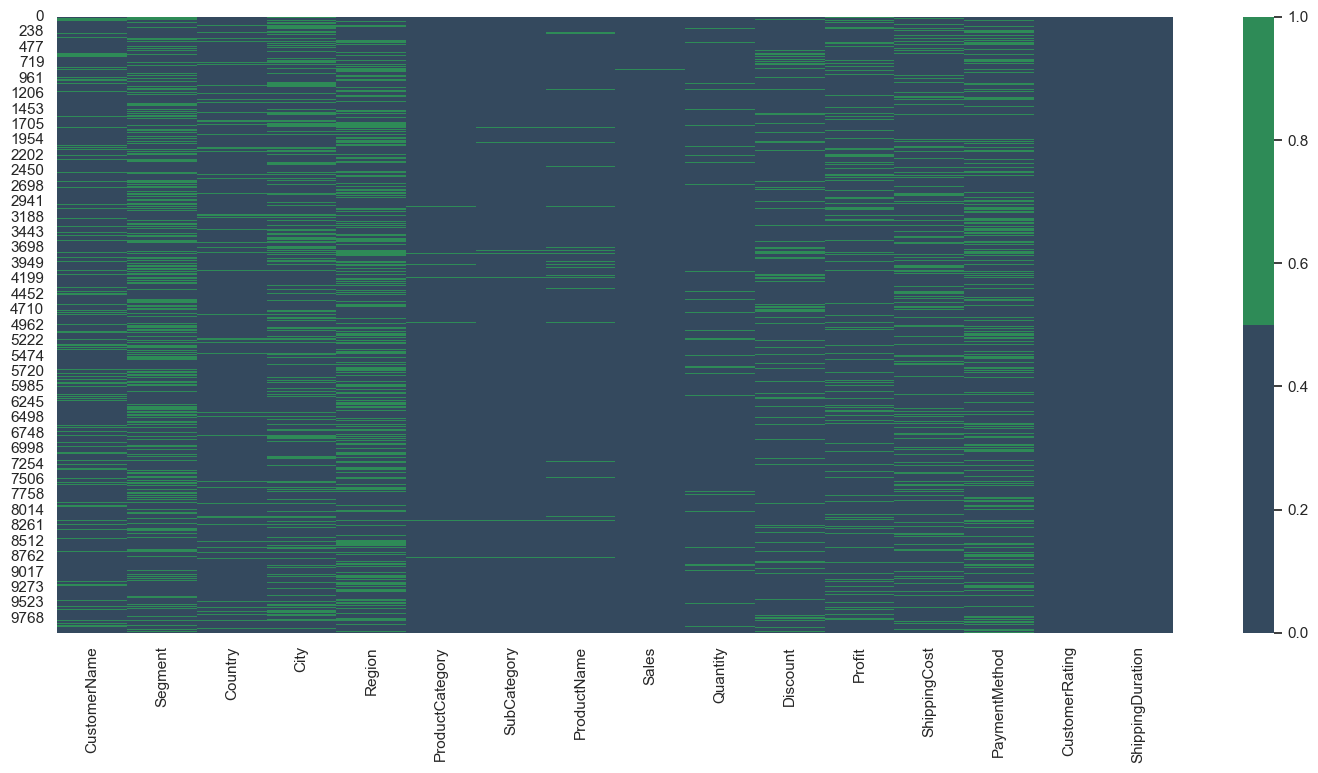

In [245]:
plt.figure(figsize=(18, 8))

colours = ['#34495E', 'seagreen']
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

We have a lot of data that is missing.

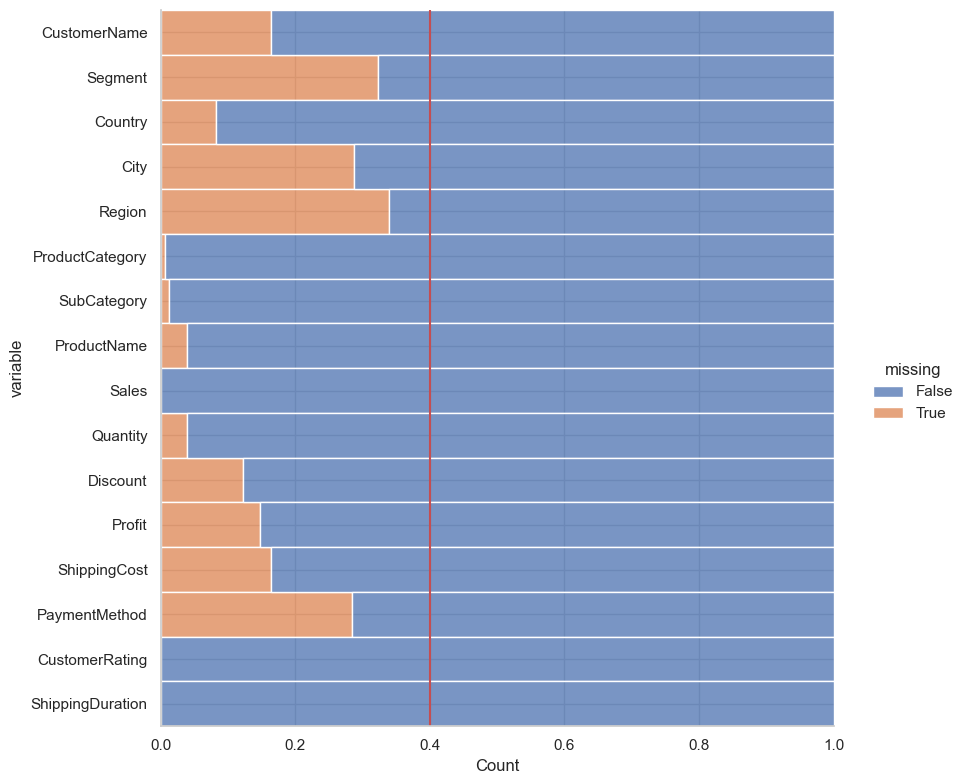

In [246]:
sns.displot(
    data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
    aspect=1.1
)

# specifying a threshold value
plt.axvline(0.4, color='r')

We have a lot of missing data in segment, city, region and paymentMethod columns.
To use an imputter on our data, I will firstly encode categorical data with label encoding, then use KNN imputer and finally I will use target encoding on those columns.

In [247]:
categorical_columns = [
    'CustomerName', 'Segment', 'Country', 'City', 'Region',
    'ProductCategory', 'SubCategory', 'ProductName', 'PaymentMethod'
]

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))

# Using StandardScaler will hellp KNNImputer to perform better as it is distance based.
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(
    imputer.fit_transform(df),
    columns=df.columns
)

df = pd.DataFrame(
    scaler.inverse_transform(df_imputed),
    columns=df_imputed.columns
)


In [248]:
df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,1.0,4.0,3.0,1.0,4.0,3.0,1.0,3.0,1575.0,16.0,50.0,600.0,43.0,0.0,-1.0,437.0
1,4.0,2.0,0.0,5.0,1.0,2.0,4.0,4.0,3705.0,9.0,5.0,-140.0,0.0,4.0,1.0,215.0
2,2.0,2.0,5.0,5.0,4.0,3.0,1.0,3.0,2499.0,18.0,10.0,-500.0,500.0,0.0,3.0,196.0
3,3.0,4.0,4.0,2.0,0.0,2.0,4.0,4.0,1371.0,10.0,110.0,-500.0,124.0,1.0,-1.0,529.0
4,5.0,0.0,2.0,0.0,4.0,2.0,4.0,4.0,3360.0,3.0,8.0,500.0,21.0,4.0,-1.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,4.0,0.0,1.0,3.0,3.0,5.0,0.0,0.0,3325.0,-5.0,110.0,-100.0,0.0,5.0,1.0,215.0
9496,5.0,2.0,4.0,2.0,3.0,2.0,4.0,4.0,541.0,0.0,25.0,-100.0,10.0,4.0,100.0,215.0
9497,1.0,3.0,2.0,0.0,1.0,2.0,4.0,4.0,1840.0,7.0,0.0,-500.0,0.0,5.0,100.0,215.0
9498,4.0,2.0,4.0,2.0,2.0,4.0,3.0,1.0,847.0,9.0,-10.0,1000.0,10.0,0.0,-1.0,332.0


Next, we will encode the values. The reason why I want to use target encoding over frequency encoding for most of my columns is beacuse I think that each value can influence unequally the rating: a customer can be more bias towards putting more good reviews than the other or customers for binder set are easier to satisfy so they will put greater ratings.

In [249]:
categorical_columns = [
    "CustomerName",
    "Segment",
    "Country",
    "City",
    "Region",
    "ProductCategory",
    "SubCategory",
    "ProductName",
]

encoder = ce.TargetEncoder(cols=categorical_columns)

df = encoder.fit_transform(df, df['CustomerRating'])

df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,12.961326,12.473375,13.005627,13.433163,13.911573,12.746115,13.739496,13.739496,1575.0,16.0,50.0,600.0,43.0,0.0,-1.0,437.0
1,13.160612,14.504837,13.922901,13.193986,14.055341,13.704570,13.887750,13.887750,3705.0,9.0,5.0,-140.0,0.0,4.0,1.0,215.0
2,13.395702,14.504837,12.506989,13.193986,13.911573,12.746115,13.739496,13.739496,2499.0,18.0,10.0,-500.0,500.0,0.0,3.0,196.0
3,13.986734,12.473375,14.212900,13.562135,12.426807,13.704570,13.887750,13.887750,1371.0,10.0,110.0,-500.0,124.0,1.0,-1.0,529.0
4,14.143774,13.534493,13.104287,13.779357,13.911573,13.704570,13.887750,13.887750,3360.0,3.0,8.0,500.0,21.0,4.0,-1.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,13.160612,13.534493,13.387815,13.376833,13.625332,13.669325,13.661255,13.661255,3325.0,-5.0,110.0,-100.0,0.0,5.0,1.0,215.0
9496,14.143774,14.504837,14.212900,13.562135,13.625332,13.704570,13.887750,13.887750,541.0,0.0,25.0,-100.0,10.0,4.0,100.0,215.0
9497,12.961326,14.088729,13.104287,13.779357,14.055341,13.704570,13.887750,13.887750,1840.0,7.0,0.0,-500.0,0.0,5.0,100.0,215.0
9498,13.160612,14.504837,14.212900,13.562135,12.756892,13.654844,13.702790,13.702790,847.0,9.0,-10.0,1000.0,10.0,0.0,-1.0,332.0


For PaymentMethod, I will use FrequencyEncoder, as usually I payment methods that are more popular have better integration and experience: ex: something like credit card might be better supported on the websites then crypto.

In [250]:
encoder = CountEncoder(cols=["PaymentMethod"], normalize=False)
df["PaymentMethod"] = encoder.fit_transform(df[["PaymentMethod"]])["PaymentMethod"]
df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,12.961326,12.473375,13.005627,13.433163,13.911573,12.746115,13.739496,13.739496,1575.0,16.0,50.0,600.0,43.0,1354,-1.0,437.0
1,13.160612,14.504837,13.922901,13.193986,14.055341,13.704570,13.887750,13.887750,3705.0,9.0,5.0,-140.0,0.0,1422,1.0,215.0
2,13.395702,14.504837,12.506989,13.193986,13.911573,12.746115,13.739496,13.739496,2499.0,18.0,10.0,-500.0,500.0,1354,3.0,196.0
3,13.986734,12.473375,14.212900,13.562135,12.426807,13.704570,13.887750,13.887750,1371.0,10.0,110.0,-500.0,124.0,1354,-1.0,529.0
4,14.143774,13.534493,13.104287,13.779357,13.911573,13.704570,13.887750,13.887750,3360.0,3.0,8.0,500.0,21.0,1422,-1.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,13.160612,13.534493,13.387815,13.376833,13.625332,13.669325,13.661255,13.661255,3325.0,-5.0,110.0,-100.0,0.0,2702,1.0,215.0
9496,14.143774,14.504837,14.212900,13.562135,13.625332,13.704570,13.887750,13.887750,541.0,0.0,25.0,-100.0,10.0,1422,100.0,215.0
9497,12.961326,14.088729,13.104287,13.779357,14.055341,13.704570,13.887750,13.887750,1840.0,7.0,0.0,-500.0,0.0,2702,100.0,215.0
9498,13.160612,14.504837,14.212900,13.562135,12.756892,13.654844,13.702790,13.702790,847.0,9.0,-10.0,1000.0,10.0,1354,-1.0,332.0


Now, we have a successfully cleaned and preprocessed our dataset.

# Data visualization

<Axes: >

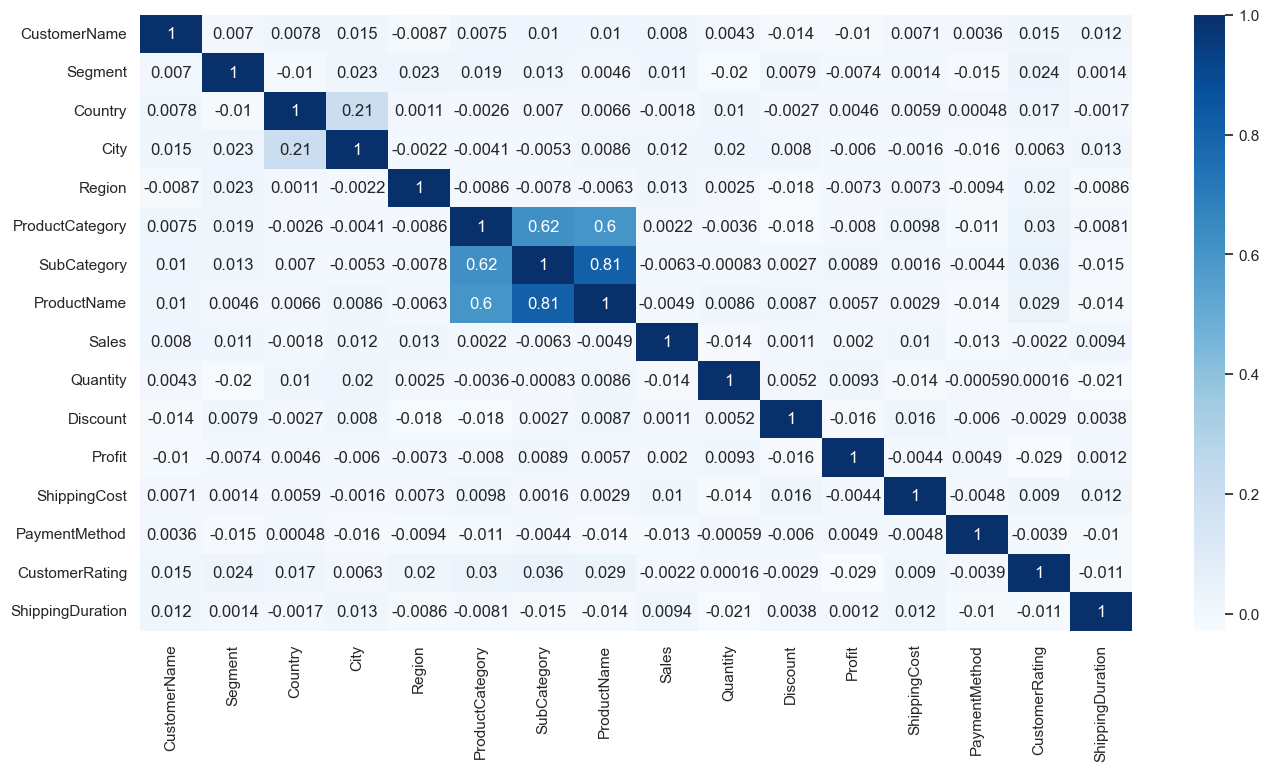

In [251]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 8)
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Blues)

The most influential columns on CustomerRating is SubCategory, ProductCategory, ShippingDuration.

<Axes: xlabel='ShippingDuration', ylabel='CustomerRating'>

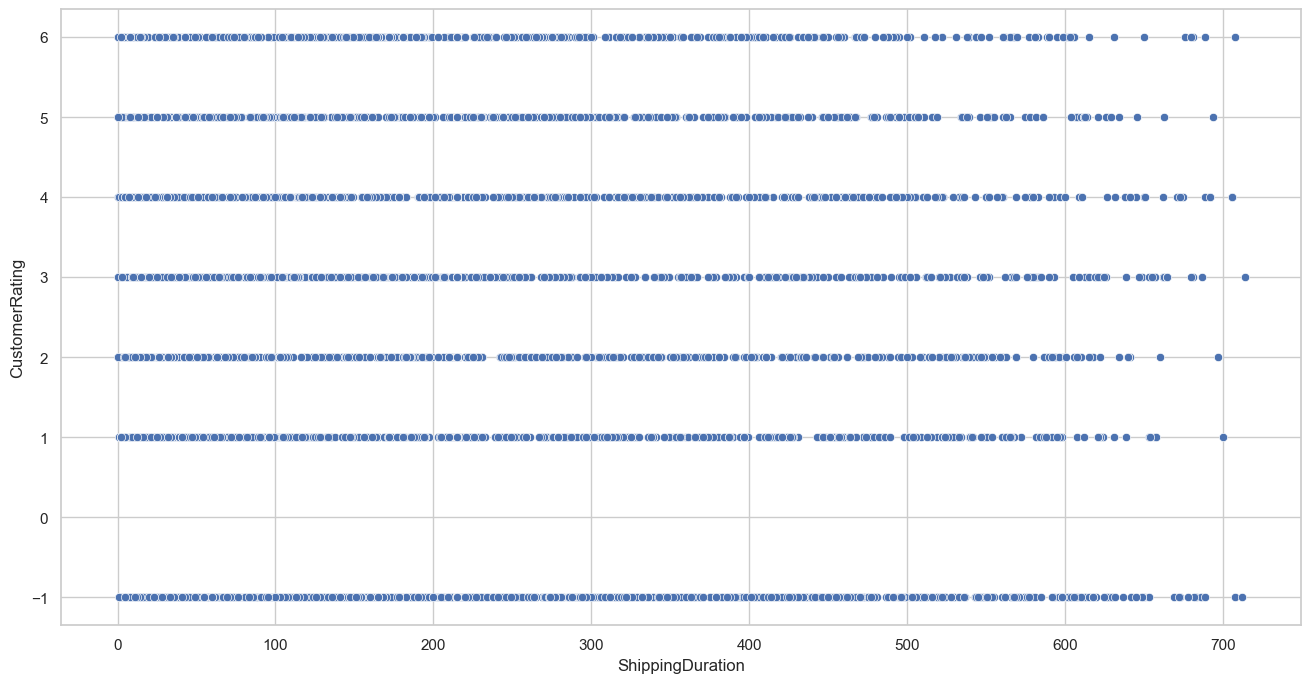

In [252]:
sns.scatterplot(x="ShippingDuration", y="CustomerRating", data=df[df['CustomerRating'] < 100])

The shipping duration is more or less even across all ratings.

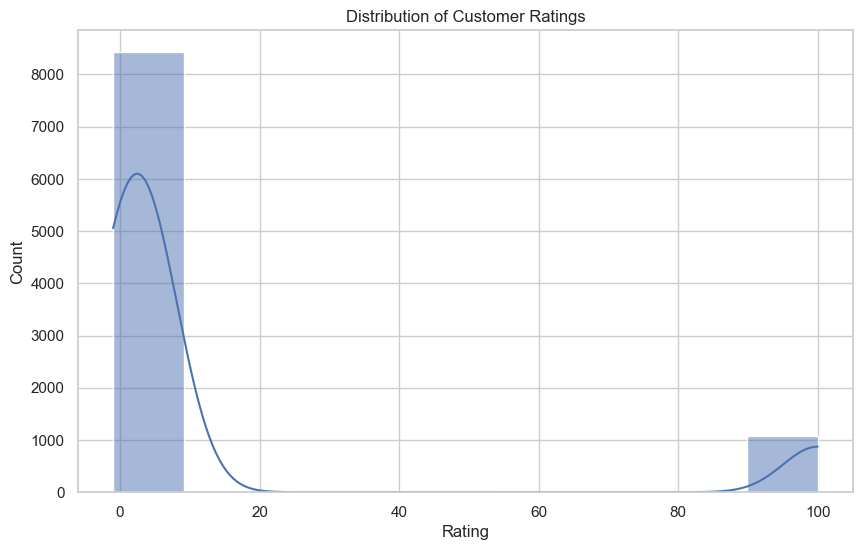

In [253]:
plt.figure(figsize=(10, 6))
sns.histplot(df["CustomerRating"], kde=True, bins=10)
plt.title("Distribution of Customer Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

We see that most of the data is in the interval [-1; 10], this makes me think if ratings above 95 are outliers or not. Let's explore further our dataset.

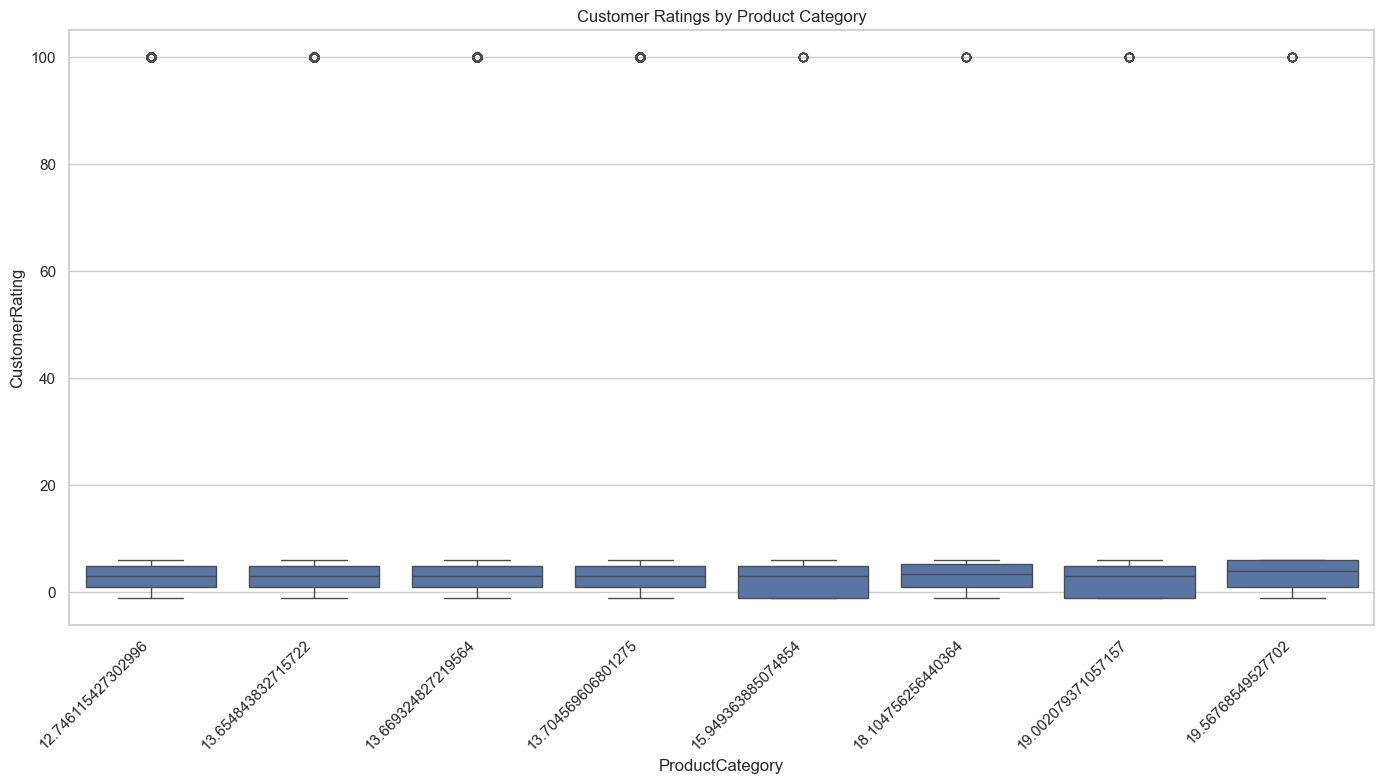

In [254]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="ProductCategory", y="CustomerRating", data=df)
plt.title("Customer Ratings by Product Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Our previous is conclusion, is further seen in this plots, as the box plot sets those with ratings 100 as outliers.

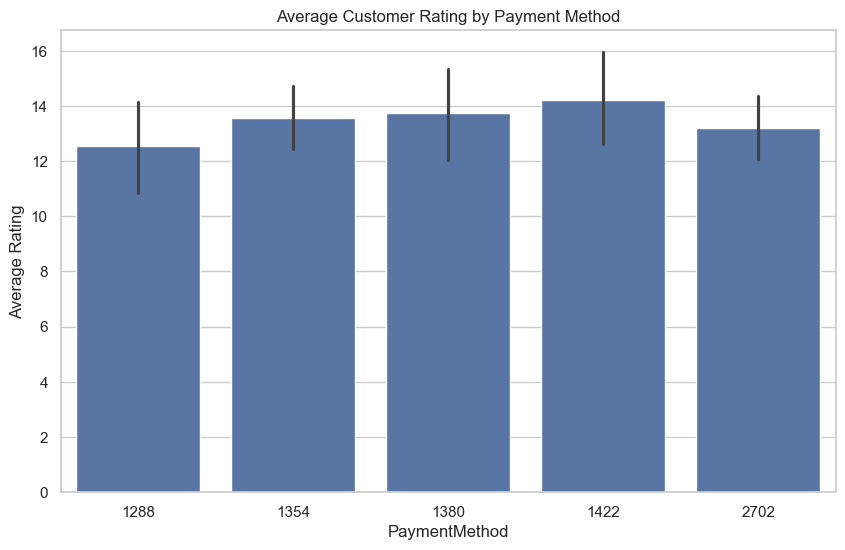

In [255]:
plt.figure(figsize=(10, 6))
sns.barplot(x="PaymentMethod", y="CustomerRating", data=df)
plt.title("Average Customer Rating by Payment Method")
plt.ylabel("Average Rating")
plt.show()

because of those 100 ratings, the data is more or less equal or it needs some scalling.

In [ ]:
sns.pairplot(data=df[['CustomerRating', 'Segment', 'Country', 'ProductCategory',
                      'SubCategory', 'Sales', 'Quantity', 'Discount', 'Profit',
                      'ShippingDuration', 'PaymentMethod']], hue='CustomerRating',
             height=1.5)

The 100's are still pretty much outlied in every chart. Let's see how many rows there are.

In [176]:
df[df['CustomerRating'] > 95].count()

CustomerName        1074
Segment             1074
Country             1074
City                1074
Region              1074
ProductCategory     1074
SubCategory         1074
ProductName         1074
Sales               1074
Quantity            1074
Discount            1074
Profit              1074
ShippingCost        1074
PaymentMethod       1074
CustomerRating      1074
ShippingDuration    1074
dtype: int64

# Outlier detection
Next, we are gonna try get rid of outliers and run the data visualization once again. I will train a RandomForest model because this is problem of classification as there aren't that many values for the target column. I will try some algorithms to see if they will improve our model. I am very biased towards  dropping the 100's as we will still have much data to work, another way would be to replace all 100's with a value lower like a 7, that would help, but I am not sure what is the cause of such high ratings, maybe it is a bug in the system and even the data that is also invalid. 

In [177]:
# We should split our data to have data to work on and to test on. 
X_train, X_test, y_train, y_test = train_test_split(df.drop('CustomerRating', axis=1),
                                                    df['CustomerRating'],
                                                    test_size=0.2,
                                                    random_state=42)

In [178]:
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

        -1.0       0.20      0.40      0.27       392
         1.0       0.15      0.15      0.15       193
         2.0       0.09      0.10      0.09       210
         3.0       0.13      0.10      0.11       214
         4.0       0.08      0.05      0.06       234
         5.0       0.10      0.06      0.07       220
         6.0       0.10      0.06      0.07       206
       100.0       0.11      0.06      0.08       231

    accuracy                           0.15      1900
   macro avg       0.12      0.12      0.11      1900
weighted avg       0.13      0.15      0.13      1900



We have an awful performing model, it guesses best the missing values than all other values having a f1 score of 0.28, while the least accurate class is 5.0 ratings. Let's see if dropping 100's improves it any better?

In [179]:
# filter out rows where CustomerRating is 100
df_filtered = df[df['CustomerRating'] != 100]

X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop('CustomerRating', axis=1),
                                                    df_filtered['CustomerRating'],
                                                    test_size=0.2,
                                                    random_state=42)

# Train the model
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions and evaluate
predicted = rfc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

        -1.0       0.25      0.43      0.31       403
         1.0       0.12      0.11      0.11       209
         2.0       0.12      0.11      0.11       210
         3.0       0.12      0.09      0.10       233
         4.0       0.14      0.11      0.12       197
         5.0       0.12      0.08      0.10       224
         6.0       0.10      0.06      0.08       210

    accuracy                           0.17      1686
   macro avg       0.14      0.14      0.14      1686
weighted avg       0.15      0.17      0.15      1686



The performance has overall improved but not for much, the f1 score for -1 has increased from 0.28 to 0.31. The reason why only -1's have been improved as there I think there the classes are not as balanced, we will do some class balancing later.

## Let's see the previous plots using this dataset and compare

In [180]:
df = df_filtered

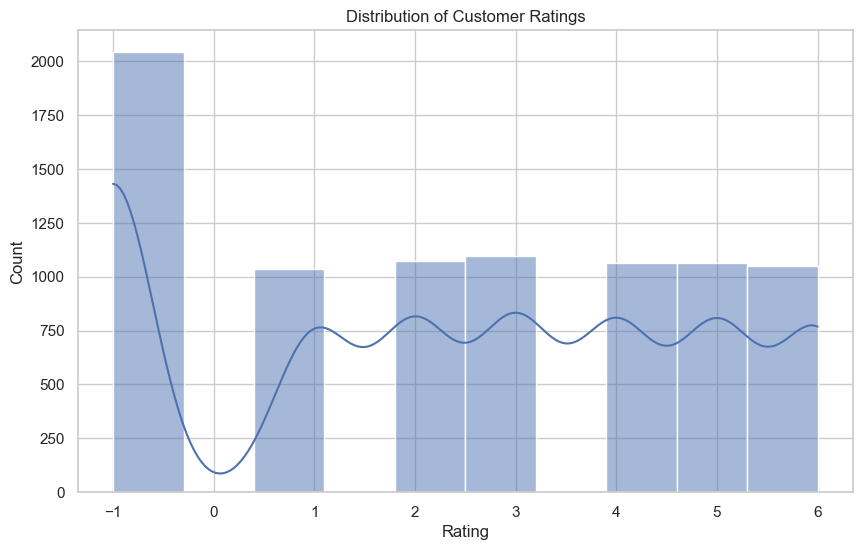

In [181]:
plt.figure(figsize=(10, 6))
sns.histplot(df["CustomerRating"], kde=True, bins=10)
plt.title("Distribution of Customer Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Now, it is easier to judge for the first all columns. I see that the -1 class has more data, but the rest has more or less the same amount of data per class. This is a issue of class balancing, I think it would be best to use undersampling for this as one class has more data then the others. Elimnating some data would not affect so much our results. 

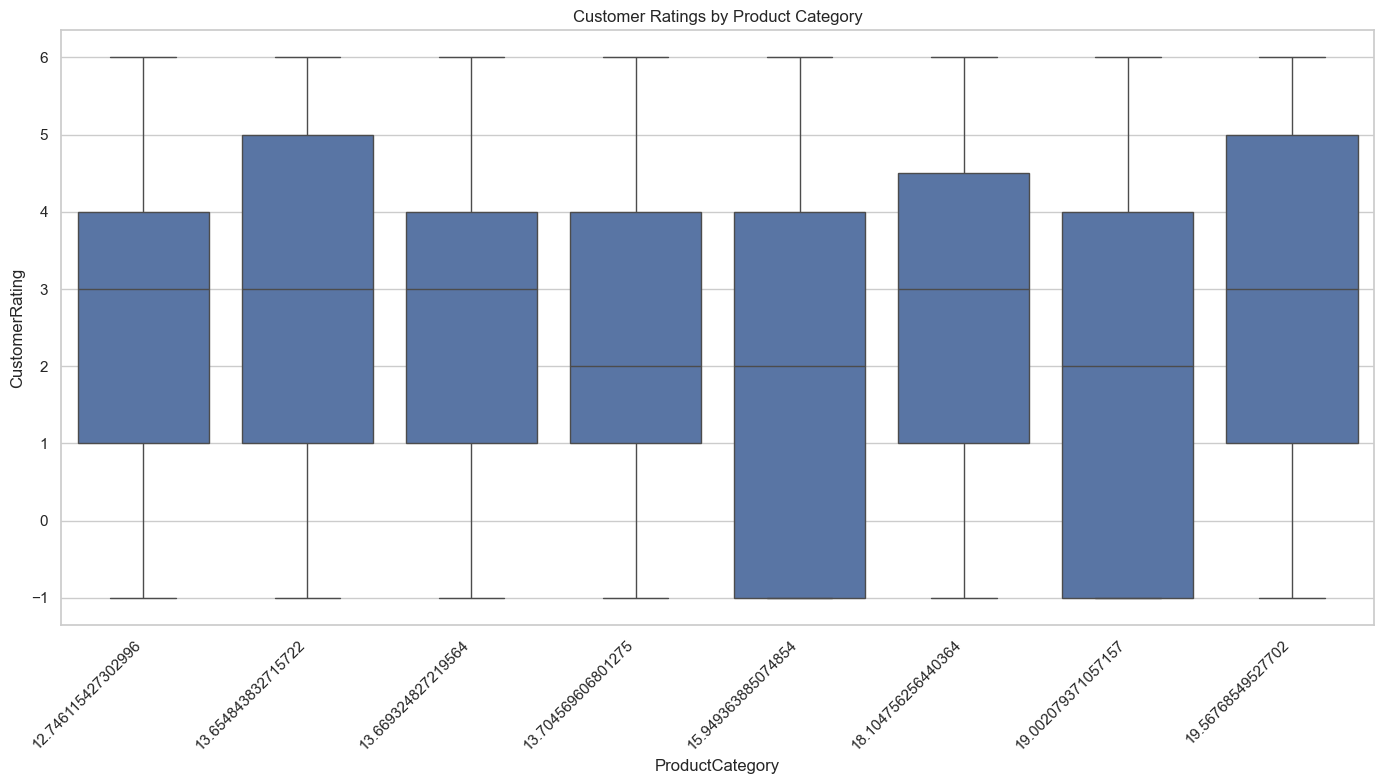

In [182]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="ProductCategory", y="CustomerRating", data=df)
plt.title("Customer Ratings by Product Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

I see that, only 2 categories has -1 scores.

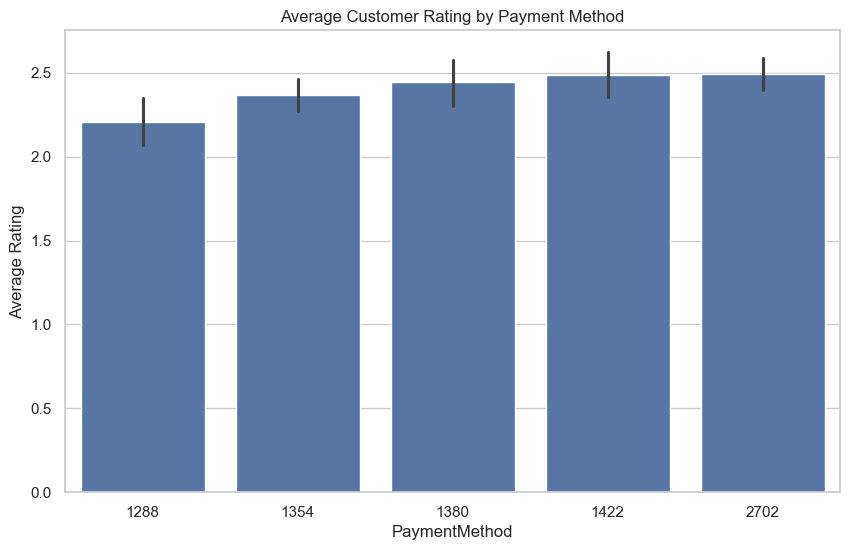

In [183]:
plt.figure(figsize=(10, 6))
sns.barplot(x="PaymentMethod", y="CustomerRating", data=df)
plt.title("Average Customer Rating by Payment Method")
plt.ylabel("Average Rating")
plt.show()

The more popular payment method orders, have better rating.

Now let's try other outlier methods, to see if we can improve on, I will try 2  methods to visualize the outliers: Isolation Forest and OneClassSVM.

In [184]:
df = df_filtered
# Models
models = {
    "Isolation Forest": IsolationForest(contamination=0.1, random_state=42),
    "OneClassSVM": OneClassSVM(nu=0.1, kernel='rbf', gamma='scale'),
}
outlier_preds = {}
for model_name, model in models.items():
    outlier_preds[model_name] = model.fit_predict(df.drop('CustomerRating', axis=1))


Next, we will create some scatter plots to better visualize the outliers, I will as apply PCA so we create minimze the features to 2 and a StandardScaler so we could visualize the data more clearly. 

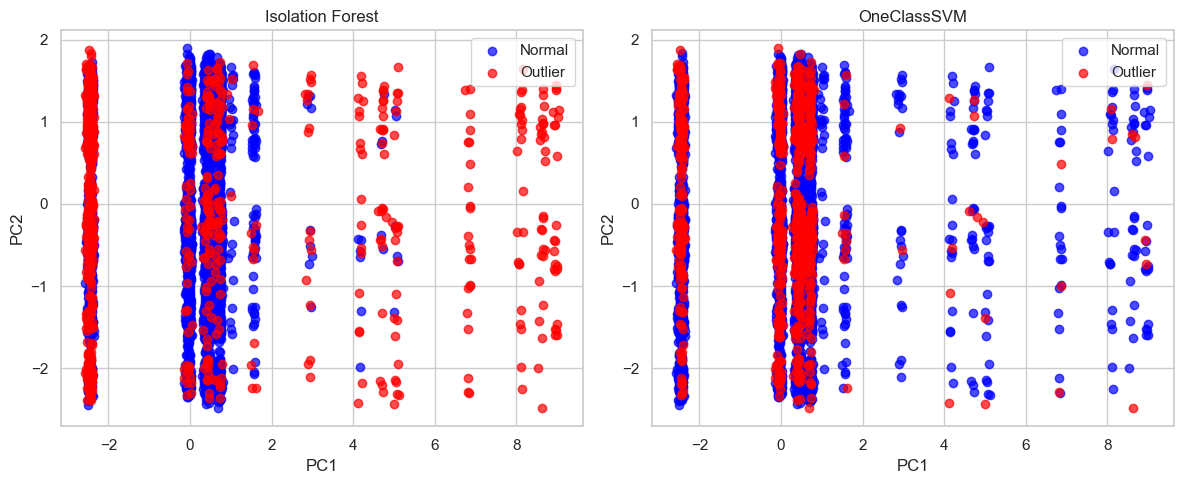

In [185]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('CustomerRating', axis=1))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot each model
for i, (model_name, predictions) in enumerate(outlier_preds.items()):
    ax = axes[i]

    # Plot inliers and outliers
    ax.scatter(X_pca[predictions == 1, 0], X_pca[predictions == 1, 1],
               c='blue', label='Normal', alpha=0.7)

    ax.scatter(X_pca[predictions == -1, 0], X_pca[predictions == -1, 1],
               c='red', label='Outlier', alpha=0.7)

    # Simple labels
    ax.set_title(model_name)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()

plt.tight_layout()
plt.show()

Both methods, found more or less the same amount of outliers, but Isolation Forest has more outliers in the intervals [-2;-1] and [4;8] while the OneClassSVM has more data between [0;2]. Next we will train our model with dataset based on both algorithms and see which one is better. 

In [186]:
# Results dictionary
results = {}

# For each outlier detection method
for model_name, predictions in outlier_preds.items():
    # Create mask for inliers (prediction value of 1)
    inlier_mask = predictions == 1

    # Filter the dataset to keep only inliers
    df_filtered = df[inlier_mask]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        df_filtered.drop('CustomerRating', axis=1),
        df_filtered['CustomerRating'],
        test_size=0.2,
        random_state=42
    )

    # Train the Random Forest model
    rfc = RandomForestClassifier(n_estimators=5, random_state=42)
    rfc.fit(X_train, y_train)

    # Make predictions
    predicted = rfc.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average='weighted')
    recall = recall_score(y_test, predicted, average='weighted')
    f1 = f1_score(y_test, predicted, average='weighted')

    # Store results
    results[f"RFC with {model_name} filtering"] = {
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3)
    }

# Create a results table
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1 Score
RFC with Isolation Forest filtering,0.163,0.145,0.163,0.145
RFC with OneClassSVM filtering,0.183,0.159,0.183,0.161


The OneClassSVM, has better output output than IsolationForest and the previous trained  models as it has the best f1 score. Next I will use the dataset created by OneClassSVM for our future experiments.

In [187]:
df = df[outlier_preds["OneClassSVM"] == 1]

In [188]:
df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,CustomerRating,ShippingDuration
0,12.961326,12.473375,13.005627,13.433163,13.911573,12.746115,13.739496,13.739496,1575.0,16.0,50.0,600.0,43.0,1354,-1.0,437.0
1,13.160612,14.504837,13.922901,13.193986,14.055341,13.704570,13.887750,13.887750,3705.0,9.0,5.0,-140.0,0.0,1422,1.0,215.0
2,13.395702,14.504837,12.506989,13.193986,13.911573,12.746115,13.739496,13.739496,2499.0,18.0,10.0,-500.0,500.0,1354,3.0,196.0
3,13.986734,12.473375,14.212900,13.562135,12.426807,13.704570,13.887750,13.887750,1371.0,10.0,110.0,-500.0,124.0,1354,-1.0,529.0
4,14.143774,13.534493,13.104287,13.779357,13.911573,13.704570,13.887750,13.887750,3360.0,3.0,8.0,500.0,21.0,1422,-1.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,13.986734,12.473375,14.212900,13.562135,12.426807,12.746115,13.739496,13.739496,2268.0,11.0,0.0,-100.0,10.0,2702,-1.0,215.0
9494,13.160612,13.432361,13.922901,13.193986,13.625332,13.654844,13.702790,13.702790,2588.0,16.0,-4.0,1000.0,500.0,1354,2.0,215.0
9495,13.160612,13.534493,13.387815,13.376833,13.625332,13.669325,13.661255,13.661255,3325.0,-5.0,110.0,-100.0,0.0,2702,1.0,215.0
9498,13.160612,14.504837,14.212900,13.562135,12.756892,13.654844,13.702790,13.702790,847.0,9.0,-10.0,1000.0,10.0,1354,-1.0,332.0


## Class balancing 
Next, I will try one method of oversampling and one of undersampling. 

In [189]:
X = df.drop('CustomerRating', axis=1)
y = df['CustomerRating']

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42
)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42
)

undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42
)

print("\nUndersampled class distribution:")
print(pd.Series(y_under).value_counts())

datasets = {
    "Original": (X_train_orig, X_test_orig, y_train_orig, y_test_orig),
    "SMOTE": (X_train_smote, X_test_smote, y_train_smote, y_test_smote),
    "Undersampled": (X_train_under, X_test_under, y_train_under, y_test_under)
}

reports = {}

for name, (X_train, X_test, y_train, y_test) in datasets.items():
    print(f"\n{'=' * 50}")
    print(f"Training Random Forest on {name} dataset")
    print(f"{'=' * 50}")

    rfc = RandomForestClassifier(n_estimators=5, random_state=42)
    rfc.fit(X_train, y_train)

    predictions = rfc.predict(X_test)

    report = classification_report(y_test, predictions, output_dict=True)
    reports[name] = report

    print(f"\nClassification Report for RFC with {name} dataset:")
    print(classification_report(y_test, predictions))

    accuracy = accuracy_score(y_test, predictions)
    print(f"Overall Accuracy: {accuracy:.3f}")


Undersampled class distribution:
CustomerRating
-1.0    928
 1.0    928
 2.0    928
 3.0    928
 4.0    928
 5.0    928
 6.0    928
Name: count, dtype: int64

Training Random Forest on Original dataset

Classification Report for RFC with Original dataset:
              precision    recall  f1-score   support

        -1.0       0.24      0.46      0.32       354
         1.0       0.16      0.14      0.15       201
         2.0       0.16      0.13      0.14       212
         3.0       0.12      0.10      0.11       177
         4.0       0.13      0.09      0.11       186
         5.0       0.08      0.05      0.06       185
         6.0       0.14      0.08      0.10       202

    accuracy                           0.18      1517
   macro avg       0.15      0.15      0.14      1517
weighted avg       0.16      0.18      0.16      1517

Overall Accuracy: 0.183

Training Random Forest on SMOTE dataset

Classification Report for RFC with SMOTE dataset:
              precision    rec

My previous conclusion that overfitting might be the best has been wronged. SMOTE, clearly outperforms everything here, even though the f1 score for -1 class has decreased from 0.31 to 0.27, the overall performance of the model has been increased. 

Let's also see what would happen if we would drop -1 class as it is the most unbalanced.

In [190]:
# filter out rows where CustomerRating is 100
df_filtered = df[df['CustomerRating'] != -1]

X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop('CustomerRating', axis=1),
                                                    df_filtered['CustomerRating'],
                                                    test_size=0.2,
                                                    random_state=42)

# Train the model
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions and evaluate
predicted = rfc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

         1.0       0.19      0.27      0.22       205
         2.0       0.11      0.16      0.13       174
         3.0       0.21      0.20      0.20       195
         4.0       0.13      0.11      0.12       199
         5.0       0.17      0.13      0.15       170
         6.0       0.16      0.11      0.13       205

    accuracy                           0.16      1148
   macro avg       0.16      0.16      0.16      1148
weighted avg       0.16      0.16      0.16      1148



As seen, the performance has not improved at all, so I will use SMOTE for the next experminents.

In [191]:
X_original = df.drop('CustomerRating', axis=1)
y_original = df['CustomerRating']

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X_original, y_original)

df = pd.DataFrame(
    data=X,
    columns=X_original.columns
)
df['CustomerRating'] = y
df

,CustomerName,Segment,Country,City,Region,ProductCategory,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,PaymentMethod,ShippingDuration,CustomerRating
0,12.961326,12.473375,13.005627,13.433163,13.911573,12.746115,13.739496,13.739496,1575.000000,16.000000,50.000000,600.00000,43.000000,1354,437.000000,-1.0
1,13.160612,14.504837,13.922901,13.193986,14.055341,13.704570,13.887750,13.887750,3705.000000,9.000000,5.000000,-140.00000,0.000000,1422,215.000000,1.0
2,13.395702,14.504837,12.506989,13.193986,13.911573,12.746115,13.739496,13.739496,2499.000000,18.000000,10.000000,-500.00000,500.000000,1354,196.000000,3.0
3,13.986734,12.473375,14.212900,13.562135,12.426807,13.704570,13.887750,13.887750,1371.000000,10.000000,110.000000,-500.00000,124.000000,1354,529.000000,-1.0
4,14.143774,13.534493,13.104287,13.779357,13.911573,13.704570,13.887750,13.887750,3360.000000,3.000000,8.000000,500.00000,21.000000,1422,215.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12896,13.474327,12.473375,13.064882,13.641085,13.625332,13.663541,13.677844,13.677844,1438.189302,9.204160,23.198217,428.10698,3.994057,1381,255.339972,6.0
12897,14.062792,13.520958,12.933591,13.282543,13.985711,13.222196,13.699149,13.699149,2855.027875,6.860627,26.794426,100.00000,4.843206,1422,139.445991,6.0
12898,13.999393,13.355059,13.170274,13.224118,13.791889,13.581593,13.543662,13.543662,2395.727775,-2.838784,6.612161,-500.00000,63.546753,1356,122.106405,6.0
12899,13.395702,13.276147,13.054658,13.605209,13.402174,13.228253,13.814073,13.814073,3534.635618,12.036438,0.060730,1000.00000,52.788469,1380,433.820885,6.0


## Feature selection
Next, I will try to use 2 algorithms to find some top features and we will train our model on that.

In [193]:
correlations = r_regression(X, y, center=True)

correlation_df = pd.DataFrame({
    "Feature": X.columns,
    "Correlation": correlations
})

correlation_df

,Feature,Correlation
0,CustomerName,0.017552
1,Segment,0.006726
2,Country,0.018634
3,City,0.000367
4,Region,0.008198
5,ProductCategory,0.001973
6,SubCategory,0.000445
7,ProductName,0.002749
8,Sales,-0.023216
9,Quantity,0.028660


I will select Quantity, PaymentMethod, Country, CustomerName as they are the values with most correlation and will train our model. 

In [194]:
train_columns = ['Quantity', 'PaymentMethod', 'Country', 'CustomerName']
# We should split our data to have data to work on and to test on. 
X_train, X_test, y_train, y_test = train_test_split(df[train_columns],
                                                    df['CustomerRating'],
                                                    test_size=0.2,
                                                    random_state=42)
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

        -1.0       0.24      0.26      0.25       398
         1.0       0.15      0.17      0.16       361
         2.0       0.17      0.17      0.17       390
         3.0       0.17      0.16      0.16       357
         4.0       0.17      0.17      0.17       360
         5.0       0.17      0.14      0.15       378
         6.0       0.15      0.15      0.15       337

    accuracy                           0.18      2581
   macro avg       0.17      0.17      0.17      2581
weighted avg       0.17      0.18      0.17      2581



We got a bad performing model, so we won't use the feature selected dataframe. 

# Trying out different models

In [195]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('CustomerRating', axis=1),
    df['CustomerRating'],
    test_size=0.2,
    random_state=42
)

knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k)

# Train the KNN classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
predicted = knn.predict(X_test)

# Generate and print the classification report
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

        -1.0       0.22      0.18      0.19       398
         1.0       0.37      0.48      0.42       361
         2.0       0.41      0.42      0.41       390
         3.0       0.35      0.39      0.37       357
         4.0       0.38      0.40      0.39       360
         5.0       0.40      0.34      0.37       378
         6.0       0.36      0.31      0.33       337

    accuracy                           0.36      2581
   macro avg       0.35      0.36      0.35      2581
weighted avg       0.35      0.36      0.35      2581



We actually have a very decent improvement using KNNClassifier over RandomForest, we got a clear improvement going for .27 to .36. It works well on our data because the dataset is small, but if we had a larger dataset we would have a computational expensive model. Next, let's try some other models.


Even though logistic regression is usually used for binary data, it has a parameter multi_class='multinomial'

In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    df[train_columns],
    df['CustomerRating'],
    test_size=0.2,
    random_state=42
)

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

predicted = log_reg.predict(X_test)

report = classification_report(y_test, predicted)
print("Logistic Regression Classification Report:")
print(report)


C:\Users\Octavian\Desktop\Exam_14_04_2025_4\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Classification Report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       398
         1.0       0.19      0.19      0.19       361
         2.0       0.16      0.13      0.15       390
         3.0       0.08      0.00      0.01       357
         4.0       0.15      0.39      0.21       360
         5.0       0.17      0.12      0.14       378
         6.0       0.14      0.27      0.18       337

    accuracy                           0.15      2581
   macro avg       0.13      0.16      0.13      2581
weighted avg       0.13      0.15      0.12      2581



C:\Users\Octavian\Desktop\Exam_14_04_2025_4\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Octavian\Desktop\Exam_14_04_2025_4\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Octavian\Desktop\Exam_14_04_2025_4\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedM

As expected, we don't have a very good performance with logistic regression, the performance is average of 0.15, as it works best with binary class + this feature is deprecated.

# Using clustering
Let's try solving the problem using clustering because it can be used as we have multiple categories, I will use KMeans, this is purely just for fun. I will choese the same number of components as we have: 7.   
I will need the data to be scaled and applied pca on. 

In [199]:
scaler = StandardScaler().set_output(transform='pandas')
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


### Using Kmeans

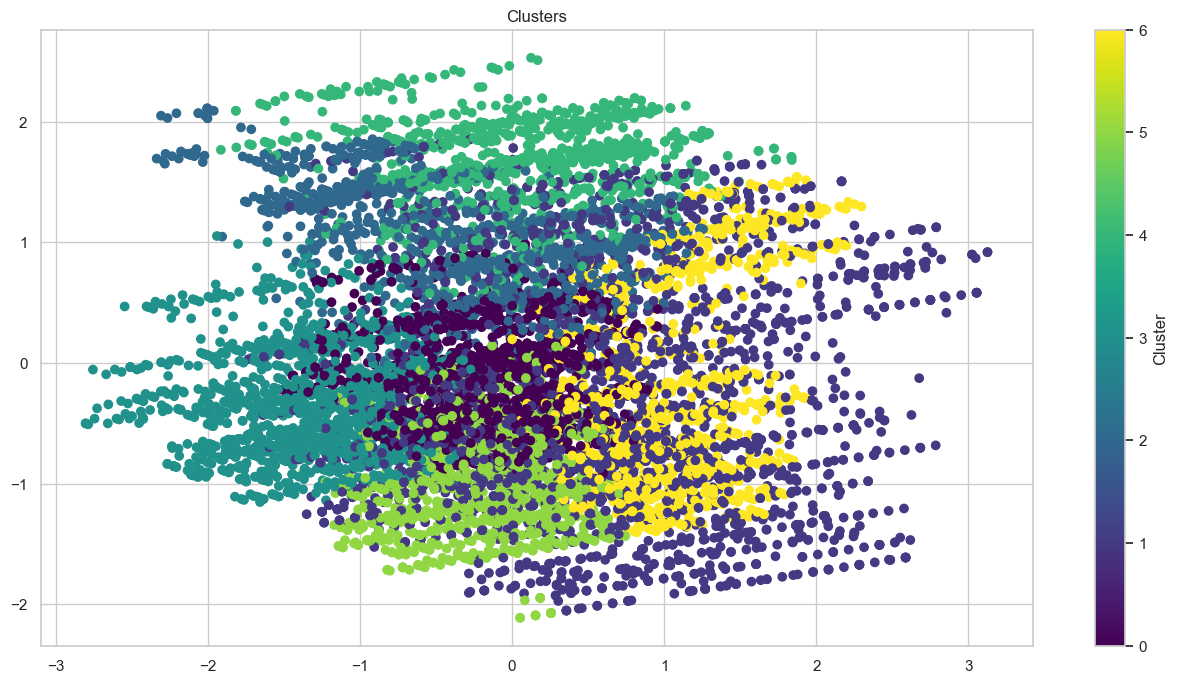

In [205]:
# Choose the optimal number of clusters (for demonstration, let's assume we selected 3)
optimal_kmeans_clusters = 7

# KMeans clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('Clusters')
plt.colorbar(label='Cluster')
plt.show()

Clustering on this many classes it is kinda hard for the algorithm. I expected to see the clusters, more isolated from each other, but it is clearly not the case. 

# Improving our model
As we decided, KNNclasfier, by now, has the best performance, I will use GridSearch in order to tune our model and find the best parameters for our model.

In [210]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='f1',
    cv=5, 
    verbose=1, 
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

# Use the best model to make predictions on the test set
best_knn = grid_search.best_estimator_
predicted = best_knn.predict(X_test)

# Generate and print the classification report
report = classification_report(y_test, predicted)
print(report)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
              precision    recall  f1-score   support

        -1.0       0.25      0.15      0.19       398
         1.0       0.56      0.60      0.58       361
         2.0       0.63      0.66      0.65       390
         3.0       0.59      0.60      0.59       357
         4.0       0.56      0.61      0.58       360
         5.0       0.57      0.61      0.59       378
         6.0       0.53      0.60      0.56       337

    accuracy                           0.54      2581
   macro avg       0.53      0.55      0.53      2581
weighted avg       0.52      0.54      0.53      2581



C:\Users\Octavian\Desktop\Exam_14_04_2025_4\venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


We managed to improve our model from 0.36 to 0.51, I am very pleased with the output of our model, especially thinking that we went from 0.16 f1 score at first. Also I see how, we get bad f1 score for -1, having 0.19 while others have 0.5, but at start we had the best scores for -1. 

In [211]:
best_knn

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

# Conclusion 
In conclusion, I had clearly have seen the power of data cleaning. If we were to start with the initial dataset, dropping all null values would left us with a small dataset. Also, I kinda liked it how using rational judgement about dataset, we found out the wrong data in our dataset and we managed to normalize it more or over. I wish I knew why there is so much wrong data, but that remains a mistery. I am pleasant that I managed to use all my knowledge gained from the Sigmoid course. I clearly enjoyed the process, tho the cleaning of data took to much thought into it. For future, I shouldn't go on purely intuition when working with datasets, at first I thought that undersampling could be the best method, but as our experiment went, oversampling was actually the better solution for us. Experiments are a huge part of data science, I must admit.